In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import adjustText
import tensorflow_hub as hub
import seaborn as sns
from sklearn.utils import resample

In [2]:
df_data = pd.read_csv('../Data/data_2/clean_review_vader_140k.csv')
df_data

,text,label
0,believe hope thing usually enjoy merritt usual...,negative
1,get bed bag hotel stay night location good que...,negative
2,ok stay family point easy get we dirty conveni...,negative
3,charge business facility service terrible room...,negative
4,hate stay homestead suite stay blotched reserv...,negative
...,...,...
143565,great hotel service stay hotel end june catch ...,positive
143566,would stay anywhere else carlyle suites hotel ...,positive
143567,love get back spend lodge street location exce...,positive
143568,highly recommend hotel anyone stay hotel day e...,positive


In [3]:
negative_reviews = df_data[df_data['label'] == 'negative']['text']
positive_reviews = df_data[df_data['label'] == 'positive']['text']
neutral_reviews = df_data[df_data['label'] == 'neutral']['text']


all_reviews = df_data['text']

vectorizer = TfidfVectorizer(stop_words='english', max_features=1000, max_df=0.5, smooth_idf=True)
tfidf_all = vectorizer.fit_transform(all_reviews)

tfidf_negative = vectorizer.transform(negative_reviews)
tfidf_positive = vectorizer.transform(positive_reviews)
tfidf_neutral = vectorizer.transform(neutral_reviews)

top_words_negative = {word: score for word, score in zip(vectorizer.get_feature_names_out(), np.max(tfidf_negative.toarray(), axis=0))} 
top_words_positive = {word: score for word, score in zip(vectorizer.get_feature_names_out(), np.max(tfidf_positive.toarray(), axis=0))}
top_words_neutral = {word: score for word, score in zip(vectorizer.get_feature_names_out(), np.max(tfidf_neutral.toarray(), axis=0))}

wordcloud_negative = WordCloud(max_font_size = 160, margin=0, background_color = "white").generate_from_frequencies(top_words_negative)
wordcloud_positive = WordCloud(max_font_size = 160, margin=0, background_color = "white").generate_from_frequencies(top_words_positive)
wordcloud_neutral = WordCloud(max_font_size = 160, margin=0, background_color = "white").generate_from_frequencies(top_words_neutral)

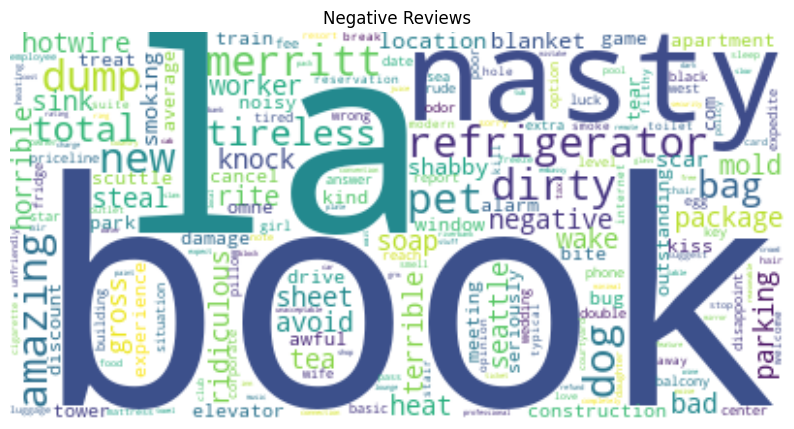

In [4]:
plt.figure(figsize=[10,10])
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Reviews')
plt.axis("off")
plt.show()


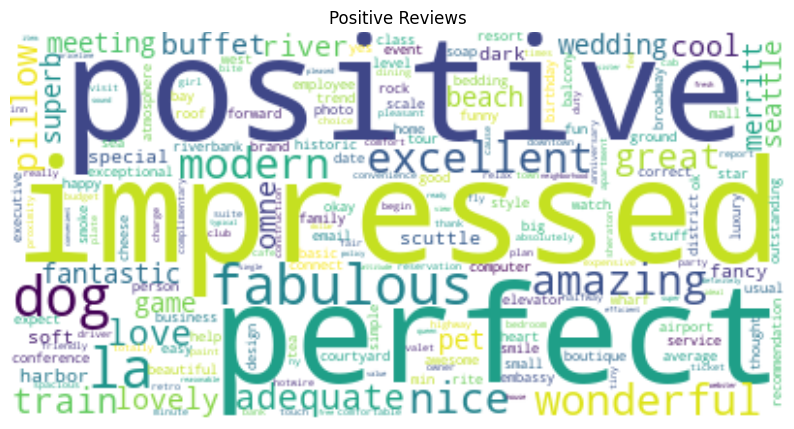

In [5]:
plt.figure(figsize=[10,10])
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Reviews')
plt.axis("off")
plt.show()


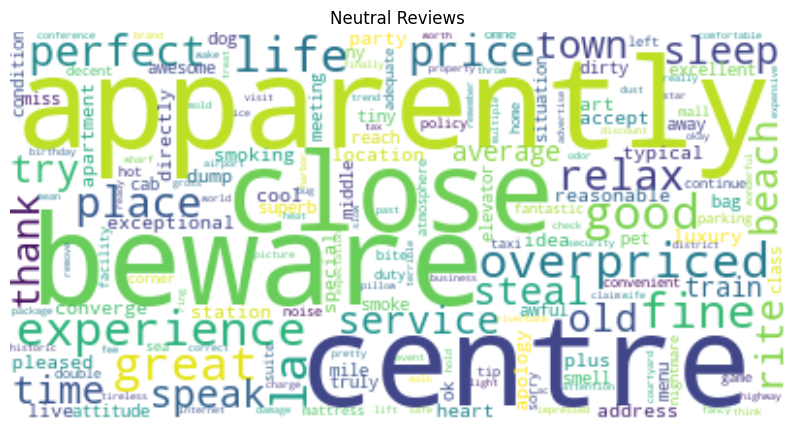

In [6]:
plt.figure(figsize=[10,10])
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.title('Neutral Reviews')
plt.axis("off")
plt.show()

In [7]:
encoding_label = {
    'positive': 0,
    'neutral': 1,
    'negative': 2
}


In [8]:
df_data['label'] = df_data['label'].map(encoding_label)
df_data

,text,label
0,believe hope thing usually enjoy merritt usual...,2
1,get bed bag hotel stay night location good que...,2
2,ok stay family point easy get we dirty conveni...,2
3,charge business facility service terrible room...,2
4,hate stay homestead suite stay blotched reserv...,2
...,...,...
143565,great hotel service stay hotel end june catch ...,0
143566,would stay anywhere else carlyle suites hotel ...,0
143567,love get back spend lodge street location exce...,0
143568,highly recommend hotel anyone stay hotel day e...,0


In [9]:
x_train, x_test, y_train, y_test = train_test_split(df_data['text'], df_data['label'], test_size=0.2, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((114856,), (28714,), (114856,), (28714,))

In [10]:
EMBEDDING_DIM = 50
MAXLEN = 50
TRUNCATING = 'post'
PADDING = 'post'
OOV_TOKEN = "<OOV>"
MAX_EXAMPLES = 10000
NUM_LABELS = 3

In [11]:
tokenizer = Tokenizer(num_words=MAX_EXAMPLES, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(x_train)

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_train_pad = pad_sequences(x_train_seq, maxlen=MAXLEN, truncating=TRUNCATING, padding=PADDING)
x_test_seq = tokenizer.texts_to_sequences(x_test)
x_test_pad = pad_sequences(x_test_seq, maxlen=MAXLEN, truncating=TRUNCATING, padding=PADDING)

In [12]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_EXAMPLES, EMBEDDING_DIM, input_length=MAXLEN),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(NUM_LABELS, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 50)            500000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 128)          58880     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1

In [14]:
history = model.fit(x_train_pad, y_train, epochs=10, validation_data=(x_test_pad, y_test), verbose=1)

Epoch 1/10
3590/3590 [==============================] - 178s 48ms/step - loss: 0.7166 - accuracy: 0.6775 - val_loss: 0.6695 - val_accuracy: 0.7003
Epoch 2/10
3590/3590 [==============================] - 169s 47ms/step - loss: 0.6420 - accuracy: 0.7144 - val_loss: 0.6575 - val_accuracy: 0.7047
Epoch 3/10
3590/3590 [==============================] - 173s 48ms/step - loss: 0.6069 - accuracy: 0.7340 - val_loss: 0.6660 - val_accuracy: 0.7026
Epoch 4/10
3590/3590 [==============================] - 169s 47ms/step - loss: 0.5697 - accuracy: 0.7547 - val_loss: 0.6781 - val_accuracy: 0.6944
Epoch 5/10
3590/3590 [==============================] - 175s 49ms/step - loss: 0.5276 - accuracy: 0.7777 - val_loss: 0.7113 - val_accuracy: 0.6923
Epoch 6/10
3590/3590 [==============================] - 185s 52ms/step - loss: 0.4804 - accuracy: 0.8025 - val_loss: 0.7471 - val_accuracy: 0.6842
Epoch 7/10
3590/3590 [==============================] - 189s 53ms/step - loss: 0.4298 - accuracy: 0.8266 - val_loss: 0

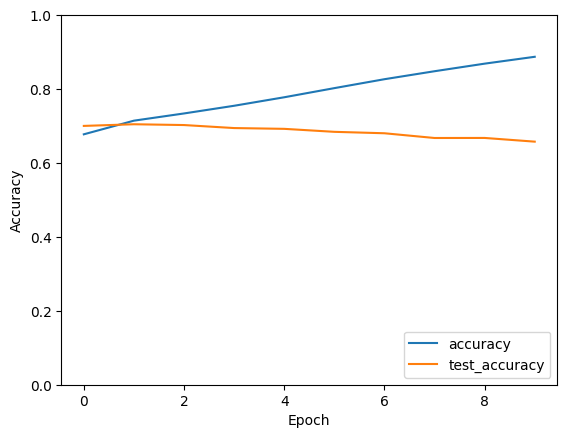

In [15]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [16]:
predictions = model.predict(x_test_pad)
predictions = np.argmax(predictions, axis=1)
y_test = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_test, predictions)

898/898 [==============================] - 15s 16ms/step


In [17]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78      9591
           1       0.55      0.56      0.55      9506
           2       0.65      0.64      0.64      9617

    accuracy                           0.66     28714
   macro avg       0.66      0.66      0.66     28714
weighted avg       0.66      0.66      0.66     28714



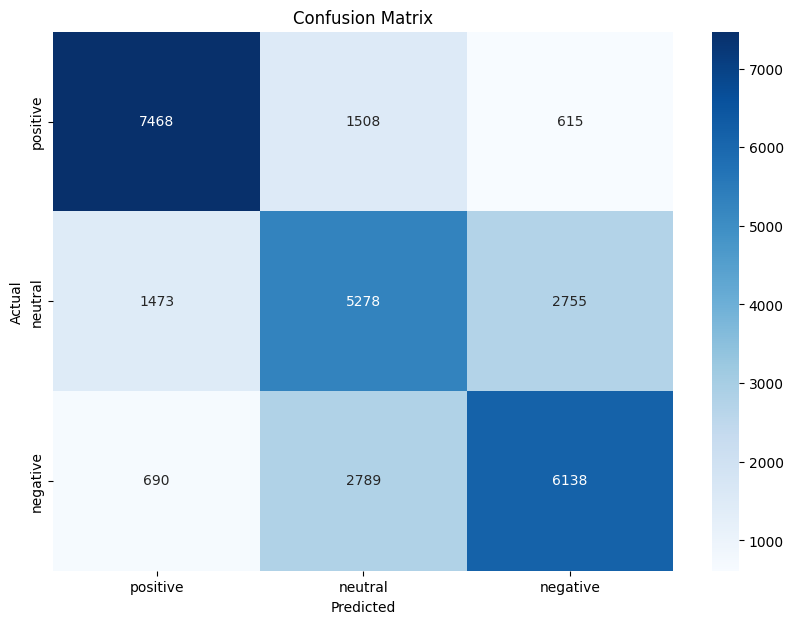

In [18]:
df_confusion_matrix = pd.DataFrame(conf_matrix, index = ['positive', 'neutral', 'negative'], columns = ['positive', 'neutral', 'negative'])
plt.figure(figsize=(10,7))
plt.title('Confusion Matrix')
sns.heatmap(df_confusion_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()